In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from torch.utils.data import DataLoader, TensorDataset

np.random.seed(1337)

# Load and process the data
aggregate_df1 = pd.read_csv('/home/awinlab/Documents/kevin/elec110.csv', index_col='datetime', parse_dates=True)
aggregate_df1 = aggregate_df1[:900000]

plug1_1 = pd.read_csv('/home/awinlab/Documents/kevin/plug1-3.csv', index_col='datetime', parse_dates=True)
plug1_1 = plug1_1[:900000]

aggregate_df1 = aggregate_df1.drop(['Unnamed: 0','id','device', 'vo', 'cu', 'reactive', 'apparent', 'pf', 'freq'], axis=1)
plug1_1 = plug1_1.drop(['Unnamed: 0','id','device', 'vo', 'cu', 'reactive', 'apparent', 'pf', 'freq'], axis=1)

/home/awinlab/anaconda3/envs/daniel_flower/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, length=100):
        self.X = X
        self.y = y
        self.length = length

    def __len__(self):
        return len(self.X) - self.length

    def __getitem__(self, idx):
        X = self.X[idx: idx + self.length]
        y = self.y[idx: idx + self.length]
        return X, y

mask = [i % 5 != 0 for i in range(len(aggregate_df1))]
X_train = aggregate_df1[~np.array(mask)]
X_test = aggregate_df1[mask]



mask1 = [i % 5 != 0 for i in range(len(plug1_1))]
y_train = plug1_1[~np.array(mask1)]
y_test = plug1_1[mask1]


X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)


X_train = torch.tensor(X_train.values).float()
X_test = torch.tensor(X_test.values).float()
y_train = torch.tensor(y_train.values).float()
y_test = torch.tensor(y_test.values).float()

batch_size=60

train_dataset = TimeSeriesDataset(X_train, y_train, length=100)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers = 0, drop_last = True, 
                                           collate_fn=lambda x: (torch.nn.utils.rnn.pad_sequence([i[0] for i in x], batch_first=True),
                                                                 torch.nn.utils.rnn.pad_sequence([i[1] for i in x], batch_first=True)))

test_dataset = TimeSeriesDataset(X_test, y_test, length=100)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers = 0, drop_last = True, 
                                           collate_fn=lambda x: (torch.nn.utils.rnn.pad_sequence([i[0] for i in x], batch_first=True),
                                                                 torch.nn.utils.rnn.pad_sequence([i[1] for i in x], batch_first=True)))

In [3]:
def rete(y_true, y_pred):
    y_true = y_true.view(-1, 1)
    y_pred = y_pred.view(-1, 1)

    # Compute the maximum value between y_true and y_pred element-wise, and reshape it to have shape (batch_size*seq_len, 1)
    max_val, _ = torch.max(torch.cat([y_pred, y_true], dim=1), dim=1, keepdim=True)

    # Compute the relative error between y_true and y_pred element-wise, and reshape it to have shape (batch_size*seq_len, 1)
    rel_err = torch.abs(y_pred - y_true) / max_val

    # Take the mean of the relative error across all samples in the batch
    return torch.mean(rel_err)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self, input_shape, n_input):
        super(Model, self).__init__()
        self.conv0 = nn.Conv1d(100, 16, kernel_size=1, stride=1, padding=1)
        self.conv1 = nn.Conv1d(16, 4, kernel_size=1, stride=1, padding=1)
        self.gru0 = nn.GRU(5, 64, num_layers=2, bidirectional=True)
        self.gru1 = nn.GRU(128, 128, num_layers=2, bidirectional=True)
        self.gru2 = nn.GRU(256, 256, num_layers=2, bidirectional=True)
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.conv0(x)
        x = self.conv1(x)
        x = self.relu(x)
        
        x, _ = self.gru0(x)

        x, _ = self.gru1(x)
        x = self.relu(x)
        
        x, _ = self.gru2(x)
        x = self.relu(x)
        x = self.fc1(x[:, -1, :])
        x = self.fc2(x)
        return x


n_input = 100
input_shape = (n_input, 1)
model = Model(input_shape, n_input)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08)
mae_fn = nn.L1Loss()

import torch.nn.functional as F
from torch.nn import L1Loss
import matplotlib.pyplot as plt
import tqdm


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
loss_fn = loss_fn.to(device)
mae_fn = mae_fn.to(device)



epochs = 5
for epoch in range(epochs):
        for i, (X_batch, y_batch) in enumerate(tqdm.tqdm(train_loader)):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch) 
            loss = loss_fn(y_pred.view(-1), y_batch.view(-1,1))
            mae = mae_fn(y_pred.view(-1), y_batch.view(-1,1))
            rete_val = rete(y_batch[:,0,:].view(-1,1), y_pred.view(-1,1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        tqdm.tqdm.write(f"Epoch [{epoch+1}/{epochs}], Step [{i}/{len(train_loader)}], Loss: {loss.item()}, MAE: {mae.item()}, Rete: {rete_val.item()}")

  0%|          | 0/2998 [00:00<?, ?it/s]/home/awinlab/anaconda3/envs/daniel_flower/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([6000, 1])) that is different to the input size (torch.Size([60])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/awinlab/anaconda3/envs/daniel_flower/lib/python3.7/site-packages/torch/nn/modules/loss.py:97: UserWarning: Using a target size (torch.Size([6000, 1])) that is different to the input size (torch.Size([60])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
100%|██████████| 2998/2998 [01:30<00:00, 33.12it/s]


Epoch [1/5], Step [2997/2998], Loss: 4.979310688213445e-06, MAE: 0.0011731927515938878, Rete: inf


100%|██████████| 2998/2998 [01:30<00:00, 33.17it/s]


Epoch [2/5], Step [2997/2998], Loss: 2.1414049115264788e-05, MAE: 0.0031035111751407385, Rete: inf


100%|██████████| 2998/2998 [01:30<00:00, 33.14it/s]


Epoch [3/5], Step [2997/2998], Loss: 6.939336890354753e-05, MAE: 0.002046267269179225, Rete: inf


100%|██████████| 2998/2998 [01:30<00:00, 33.14it/s]


Epoch [4/5], Step [2997/2998], Loss: 4.780216113431379e-05, MAE: 0.0025498871691524982, Rete: inf


100%|██████████| 2998/2998 [01:30<00:00, 33.14it/s]

Epoch [5/5], Step [2997/2998], Loss: 1.039893595589092e-05, MAE: 0.0014521850971505046, Rete: inf


In [5]:
predict = []
model = model.cpu()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predict.append(outputs[:, 0].unsqueeze(1))
predict = torch.cat(predict, dim=0)

In [6]:
predict_list = np.concatenate([p.detach().numpy() for p in predict], axis=0)

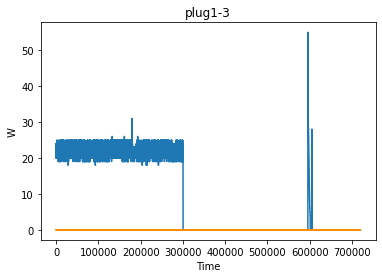

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure(facecolor='white')
plt.plot(y_test)
plt.plot(predict_list,color='darkorange')
plt.xlabel('Time')
plt.ylabel("W")
plt.title("plug1-3")
plt.savefig('/home/awinlab/Documents/kevin/WGRU/pytorch/WindowGRU_plug1-3.png')
plt.show()